In [1]:
import pyodbc
import sqlite3
import pandas as pd
import datetime as datetime
import warnings
from sklearn.model_selection import train_test_split
import random
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [4]:


DB_SOURCE = {
    'servername': r'LAPTOP-PRQNR6SS\SQLEXPRESS',
    'database': 'warehouse_united_outdoor'
}



source_conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    f"SERVER={DB_SOURCE['servername']};"
    f"DATABASE={DB_SOURCE['database']};"
    "Trusted_Connection=yes;"
)


source_cursor = source_conn.cursor()


print("Succesvol verbonden met databases!")

Succesvol verbonden met databases!


### Alle tabellen

In [5]:
# Haal een lijst van tabellen op uit de bron-database
sql_query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'"


# Gebruik pandas om de query uit te voeren en de tabellen op te halen
tables_df = pd.read_sql(sql_query, source_conn)

# Print de lijst van tabellen
tables_df

,TABLE_NAME
0,customer
1,employee
2,order_fact
3,product


In [ ]:
order_query = 'SELECT * FROM order_fact'
order_df = pd.read_sql(order_query, source_conn)

product_query = 'SELECT * FROM product'
product_df = pd.read_sql(product_query, source_conn)

employee_query = 'SELECT * FROM employee'
employee_df = pd.read_sql(employee_query, source_conn)

customers_query = 'SELECT * FROM customer'
customer_df = pd.read_sql(customers_query, source_conn)

In [78]:
order_df['product_id'] = order_df['product_id'].astype(str)
product_df['product_id'] = product_df['product_id'].astype(str)

order_merge = pd.merge(order_df, product_df, how='inner', on='product_id')

order_merge = pd.to_datetime(order_merge['order_date'], format = 'mixed')


order_merge

0        2022-07-04
1        2022-07-04
2        2022-07-04
3        2022-07-05
4        2022-07-05
            ...    
124570   2024-03-09
124571   2024-03-09
124572   2024-03-10
124573   2024-03-14
124574   2024-03-14
Name: order_date, Length: 124575, dtype: datetime64[ns]

### Dummmies maken

In [60]:
order = order_merge.loc[:, ['trademark', 'order_id', 'quantity', 'total_amount', 'unit_price']]
dummies_dataframe = pd.get_dummies(order, columns=['trademark'])
dummies_dataframe

,order_id,quantity,total_amount,unit_price,trademark_AW,trademark_AenC,trademark_NW
0,10248,12,168.00,21.00,False,False,True
1,10248,10,98.00,14.00,False,False,True
2,10248,5,174.00,34.80,False,False,True
3,10249,9,167.40,23.25,False,False,True
4,10249,40,1696.00,53.00,False,False,True
...,...,...,...,...,...,...,...
124570,67950,1,2.29,0.86,True,False,False
124571,67916,1,4.99,1.87,True,False,False
124572,68016,1,2384.07,1481.94,True,False,False
124573,68223,1,34.99,13.09,True,False,False


#### Verticaal en horizontaal snijden


In [61]:
X = dummies_dataframe.loc[dummies_dataframe['quantity'].notna(), :]
X = X.drop('quantity', axis=1)
Y = dummies_dataframe.loc[dummies_dataframe['quantity'].notna(), ['quantity']]
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124575 entries, 0 to 124574
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        124575 non-null  int64  
 1   total_amount    124575 non-null  float64
 2   unit_price      124575 non-null  float64
 3   trademark_AW    124575 non-null  bool   
 4   trademark_AenC  124575 non-null  bool   
 5   trademark_NW    124575 non-null  bool   
dtypes: bool(3), float64(2), int64(1)
memory usage: 4.2 MB


### X en Y opsplitsen op trainen en testen

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size = 0.15,
    random_state = 42
)

### RegressionModel Trainen

In [63]:
reg_model = linear_model.LinearRegression()
reg_model = reg_model.fit(X_train, y_train)

### Voorspelling maken

In [64]:
from sklearn.metrics import r2_score

y_pred = reg_model.predict(X_test)


# Evaluatie
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R²-score: {r2}")

Mean Squared Error: 12.54157942951655
R²-score: 0.5253150566483616


In [37]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns = {0 : 'Predicted_Quantity'})

In [38]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['quantity'], prediction_df], axis = 1)
y_test_prediction_merge.loc[y_test_prediction_merge['Predicted_Quantity'].notna(), :]

,quantity,Predicted_Quantity
0,1,-0.540692
1,3,2.193867
2,1,2.656140
3,4,6.916642
4,1,1.995845
...,...,...
18682,2,0.800858
18683,1,2.342682
18684,1,1.633017
18685,3,4.049023


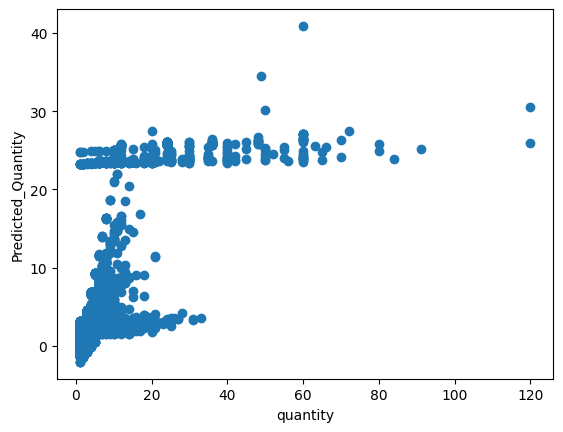

In [39]:
plt.scatter(y_test_prediction_merge['quantity'], y_test_prediction_merge['Predicted_Quantity'])
plt.xlabel('quantity')
plt.ylabel('Predicted_Quantity')
plt.show()